In [451]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy.sparse as sp
import scipy.sparse.linalg as spl

from tqdm import tqdm_notebook as tqdm
from PIL import Image

In [6]:
import warnings
warnings.filterwarnings('ignore', message='To copy construct from a tensor')

In [7]:
torch.set_default_tensor_type(torch.DoubleTensor)
# device = torch.device('cuda:0')

In [8]:
# torch.tensor(1).to(device)

In [9]:
# import os
# files = os.listdir('images')

# for i, f in enumerate(files):
#     old_name = f'gray/{f}'
#     new_name = f'gray/gray{i:02}.jpg'
#     !mv $old_name $new_name

In [10]:
def load_image(filename):
    # loads an image in grayscale
    # returns a 2D array (height x width) of intensities between 0 and 1
    img = np.asarray(Image.open(filename).convert('L')) / 255.0
    return torch.tensor(img)

def show_image(arr):
    # Takes in an gray image with intensities from 0 to 1
    arr = np.array(arr)
    arr = (arr * 255).astype(np.uint8)
    scaling = 500 / arr.shape[1]
    
    upscaled = (int(arr.shape[1] * scaling), int(arr.shape[0] * scaling))
    display(Image.fromarray(arr).resize(upscaled))

In [11]:
img = load_image('images/gray00.jpg')

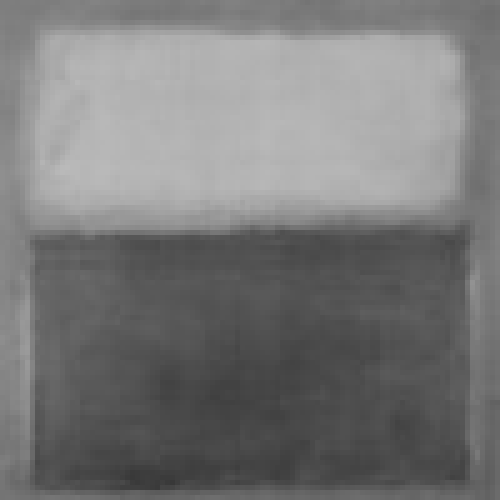

In [12]:
show_image(img)

In [609]:
def hardcode_boundary(f, internal_f):
    assert f[1:-1, 1:-1].shape == internal_f.shape

    res = f.clone()
    res[1:-1, 1:-1] = internal_f
    return res

class SecondOrderDiffEq:
    """
    A class that evaluates 2nd order nonlinear diffential equations
    of 2 variables using a discrete finite difference
    """
    def __init__(self, diff_eq_fn, num_weights, weights=None, h=0.01):
        self.diff_eq_fn = diff_eq_fn
        self.h = h
        self.num_weights = num_weights
        
        if weights is None:
            weights = torch.randn(num_weights)
        
        assert self.num_weights == len(weights)
        self.weights = torch.tensor(weights)

    def freeze(self):
        """
        Returns a copy of the SecondOrderDiffEq with weights that don't require grad
        """
        res = SecondOrderDiffEq(self.diff_eq_fn, self.num_weights, self.weights)
        res.weights.requires_grad = False
        return res

    def __call__(self, f):
        """
        Evaluate this DiffEq with the given values of the function value specified by `f`
        This uses a discrete finite difference.
        
        `f` should be a 2D torch.tensor
        """
        height, width = f.shape
        
        # constant term
        constant = torch.ones((f.shape[0] - 2, f.shape[1] - 2))
        
        # x, y coordinates
        x, y = np.meshgrid(np.arange(1, width - 1), np.arange(1, height - 1))
        x = torch.tensor(x).double() * self.h
        y = torch.tensor(y).double() * self.h
        
        # f_x and f_y
        f_x = (f[1:-1, 2:] - f[1:-1, :-2]) / (2 * self.h)
        f_y = (f[2:, 1:-1] - f[:-2, 1:-1]) / (2 * self.h)
        
        # f_xx and f_yy
        f_xx = (f[1:-1, 2:] - 2*f[1:-1,1:-1] + f[1:-1, :-2]) / (self.h ** 2)
        f_yy = (f[2:, 1:-1] - 2*f[1:-1,1:-1] + f[:-2, 1:-1]) / (self.h ** 2)
        
        # f_xy
        f_xy = (f[2:, 2:] - f[:-2, 2:] - f[2:, :-2] + f[:-2, :-2]) / (4 * self.h ** 2)
        
        # the internal part of f that excludes the boundary conditions
        f_internal = f[1:-1, 1:-1]
        
        res_internal = self.diff_eq_fn(
            weights=self.weights,
            constant=constant, x=x, y=y, f=f_internal,
            f_x=f_x, f_y=f_y, 
            f_xx=f_xx, f_xy=f_xy, f_yy=f_yy
        )
        
        return hardcode_boundary(torch.zeros(f.shape), res_internal)
    
    def fit(self, orig_image, lr=0.1, num_epochs=100, weight_penalty=0, **opt_kwargs):
        """
        Fit a differential equation to an image
        """
        orig_image = torch.tensor(orig_image).double()
        self.weights.requires_grad = True
        
        def closure():
            loss = torch.mean(self.__call__(orig_image) ** 2)
            loss += weight_penalty * torch.mean(1 / (diff_eq.weights.abs() + 1e-6))
            return loss
        
        self._lbfgs_training_loop([self.weights], closure, num_epochs, lr=lr, **opt_kwargs)
        self.weights.requires_grad = False
        return self

    def solve(self, orig_image, lr=0.1, num_epochs=100, **opt_kwargs):
        """
        Solve this differential equation using the boundary conditions
        specified by `orig_image`. Only the boundaries of `orig_image`
        are used, the remaining part of it can be arbitrary data.
        """
        internal_shape = (orig_image.shape[0] - 2, orig_image.shape[1] - 2)
        f_internal = torch.randn(internal_shape, requires_grad=True)
        
        def closure():
            f = hardcode_boundary(orig_image, f_internal)
            loss = torch.mean(self.__call__(f) ** 2)
            return loss
            
        self._lbfgs_training_loop([f_internal], closure, num_epochs, lr=lr, **opt_kwargs)
        return hardcode_boundary(orig_image, f_internal).detach()
    
    def _lbfgs_training_loop(self, parameters, closure, num_epochs=100, **opt_kwargs):
        opt = torch.optim.LBFGS(parameters, **opt_kwargs)
        
        start_time = time.time()
        last_time = None
        
        for i in range(num_epochs):
            try:
                opt.zero_grad()
                loss = closure()
                loss.backward()
                opt.step(lambda: loss)
                
                if loss.detach() < 1e-4:
                    break
                
                if last_time is None or time.time() - last_time > 1:
                    tot_time = time.time() - start_time
                    print(f'epoch {i} | {tot_time:.01f} sec | loss: {loss.detach():.3g}')
                    last_time = time.time()

            except KeyboardInterrupt:
                print('stopping early')
                break
        
        tot_time = time.time() - start_time
        print(f'epoch {i} | {tot_time:.01f} sec | loss: {loss.detach():.3g}')


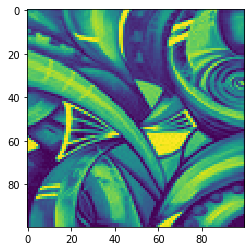

In [610]:
# def true_f(x, y):
#     x = x*0.01
#     y = y*0.01
#     return (x - x**2 + y**2) * np.exp(x)

# # generate a fake image from f(x, y) = exp(x) + exp(y)
# img = torch.zeros((10, 10))
# for x in range(10):
#     for y in range(10):
#         img[x][y] = true_f(x, y)
# img.shape

img = load_image('images/gray08.jpg')
plt.imshow(img)

In [615]:
def my_diffeq(weights, *, constant, x, y, f, f_x, f_y, f_xx, f_xy, f_yy):
    tot = 0
    w_idx = 0
    terms = [constant, x, y, f, f_x, f_y, f_xx, f_xy, f_yy]
    for t in terms[:]:
        terms.append(torch.cos(t))
    
    for i in range(len(terms)):
        tot += weights[w_idx] * terms[i]
        w_idx += 1
    
    for i in range(len(terms)):
        for j in range(i, len(terms)):
            tot += weights[w_idx] * terms[i] * terms[j]
            w_idx += 1
            
    return tot

num_weights = 18 + 18*19 // 2
diff_eq = SecondOrderDiffEq(my_diffeq, num_weights, h=0.01)
diff_eq.fit(img, lr=0.5, num_epochs=10000, weight_penalty=0)

epoch 0 | 0.0 sec | loss: 7.65e+14
epoch 78 | 1.0 sec | loss: 1.59e+08
epoch 146 | 2.0 sec | loss: 4.72e+07
epoch 210 | 3.0 sec | loss: 8.89e+06
epoch 276 | 4.1 sec | loss: 7.67e+06
epoch 344 | 5.1 sec | loss: 6.36e+06
epoch 413 | 6.1 sec | loss: 1.53e+06
epoch 482 | 7.1 sec | loss: 4.1e+05
epoch 553 | 8.1 sec | loss: 3.3e+05
epoch 622 | 9.1 sec | loss: 2.35e+05
epoch 690 | 10.1 sec | loss: 2.15e+05
epoch 753 | 11.1 sec | loss: 1.29e+05
epoch 820 | 12.1 sec | loss: 1.09e+05
epoch 885 | 13.1 sec | loss: 7.75e+04
epoch 954 | 14.1 sec | loss: 3.77e+04
epoch 1021 | 15.1 sec | loss: 3.28e+04
epoch 1091 | 16.1 sec | loss: 2.53e+04
epoch 1162 | 17.1 sec | loss: 1.81e+04
epoch 1228 | 18.2 sec | loss: 1.66e+04
epoch 1295 | 19.2 sec | loss: 1.28e+04
epoch 1364 | 20.2 sec | loss: 1.21e+04
epoch 1431 | 21.2 sec | loss: 9.42e+03
epoch 1496 | 22.2 sec | loss: 8.52e+03
epoch 1563 | 23.2 sec | loss: 8.52e+03
epoch 1626 | 24.2 sec | loss: 7.02e+03
epoch 1693 | 25.2 sec | loss: 7.02e+03
epoch 1758 | 26.

In [616]:
diff_eq.weights

tensor([-1.4790e+00,  5.5515e-01,  7.0893e-01, -7.1622e-01, -9.6662e-01,
        -6.4017e-01, -3.1987e-01, -4.6688e-01, -2.0733e-01,  1.3317e+00,
        -1.1913e+00,  2.0346e-01,  4.3389e-01,  8.0575e-02,  9.8775e-02,
         2.8802e-01, -3.9458e-01,  3.7628e-02, -2.2031e+00, -9.3876e-01,
        -8.5236e-01,  5.4125e-01, -9.2435e-01,  6.1987e-01,  2.0629e-01,
        -5.3781e-02,  6.2629e-01, -1.2672e-01,  5.7428e-01,  5.9494e-01,
         1.0628e+00,  6.6237e-01, -8.6093e-01,  4.1986e-01,  5.5908e-01,
        -8.6366e-02,  1.7747e-01,  5.9723e-01, -1.4004e+00,  7.2973e-01,
        -1.4072e+00,  3.8541e-01, -1.1796e-01, -2.6051e-01, -7.5068e-01,
         3.1135e-02, -7.4886e-01,  7.7942e-01, -4.0944e-02,  2.1773e+00,
        -5.0398e-01, -3.3264e-01, -4.8884e-01,  1.4072e+00,  8.4122e-01,
         3.6679e-01,  3.5606e-01,  1.3295e-01,  3.9589e-01,  5.3175e-02,
        -2.2828e+00, -5.8571e-01,  4.2898e-01, -6.2268e-01, -1.6868e+00,
        -5.2274e-01,  4.1660e-01,  2.7547e-02,  8.4

epoch 0 | 0.0 sec | loss: 5.67e+06
epoch 66 | 1.0 sec | loss: 5.28e+06
epoch 120 | 2.0 sec | loss: 5.24e+06
epoch 166 | 3.1 sec | loss: 5.23e+06
epoch 208 | 4.1 sec | loss: 5.22e+06
epoch 246 | 5.1 sec | loss: 5.22e+06
epoch 281 | 6.1 sec | loss: 5.22e+06
epoch 314 | 7.1 sec | loss: 5.21e+06
epoch 345 | 8.1 sec | loss: 5.21e+06
epoch 375 | 9.1 sec | loss: 5.21e+06
epoch 405 | 10.2 sec | loss: 5.21e+06
epoch 435 | 11.2 sec | loss: 5.21e+06
epoch 464 | 12.2 sec | loss: 5.21e+06
epoch 495 | 13.2 sec | loss: 5.21e+06
epoch 526 | 14.2 sec | loss: 5.21e+06
epoch 558 | 15.2 sec | loss: 5.21e+06
epoch 587 | 16.3 sec | loss: 5.21e+06
epoch 619 | 17.3 sec | loss: 5.2e+06
epoch 649 | 18.3 sec | loss: 5.2e+06
epoch 682 | 19.3 sec | loss: 5.2e+06
epoch 715 | 20.3 sec | loss: 5.2e+06
epoch 749 | 21.3 sec | loss: 5.2e+06
epoch 782 | 22.3 sec | loss: 5.2e+06
epoch 812 | 23.3 sec | loss: 5.2e+06
epoch 844 | 24.4 sec | loss: 5.2e+06
epoch 875 | 25.4 sec | loss: 5.2e+06
epoch 907 | 26.4 sec | loss: 5.2e+

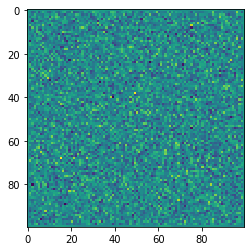

In [619]:
f = diff_eq.solve(img, lr=0.1, num_epochs=10000, history_size=300)
print('f error:', torch.mean(diff_eq(f) ** 2))
plt.imshow(f.detach().numpy());

In [593]:
img2 = torch.zeros((100, 100))
for x in range(100):
    for y in range(100):
        img2[x][y] = true_f(x, y)
img2.shape

torch.Size([100, 100])

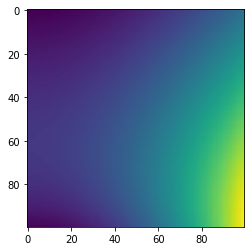

In [594]:
plt.imshow(img2)

In [544]:
%%time
f = diff_eq.solve(img2, lr=0.3, num_epochs=50000, history_size=10)

epoch 465 | 1.0 sec | loss: 2.96
epoch 932 | 2.0 sec | loss: 1.01
epoch 1404 | 3.0 sec | loss: 0.513
epoch 1863 | 4.0 sec | loss: 0.321
epoch 2301 | 5.0 sec | loss: 0.241
epoch 2751 | 6.0 sec | loss: 0.163
epoch 3241 | 7.0 sec | loss: 0.135
epoch 3716 | 8.0 sec | loss: 0.114
epoch 4199 | 9.0 sec | loss: 0.0959
epoch 4693 | 10.0 sec | loss: 0.0829
epoch 5179 | 11.0 sec | loss: 0.0674
epoch 5651 | 12.0 sec | loss: 0.0528
epoch 6112 | 13.0 sec | loss: 0.0367
epoch 6591 | 14.0 sec | loss: 0.0283
epoch 7082 | 15.0 sec | loss: 0.0216
epoch 7559 | 16.0 sec | loss: 0.018
epoch 8035 | 17.0 sec | loss: 0.0132
epoch 8518 | 18.0 sec | loss: 0.0101
epoch 8978 | 19.0 sec | loss: 0.00922
epoch 9464 | 20.0 sec | loss: 0.00837
epoch 9939 | 21.0 sec | loss: 0.00782
epoch 10406 | 22.0 sec | loss: 0.00717
epoch 10886 | 23.0 sec | loss: 0.00646
epoch 11355 | 24.0 sec | loss: 0.0058
epoch 11808 | 25.0 sec | loss: 0.00515
epoch 12279 | 26.0 sec | loss: 0.00453
epoch 12742 | 27.0 sec | loss: 0.00386
epoch 131

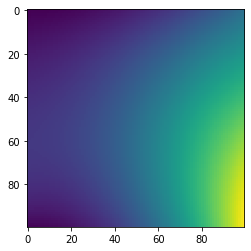

In [546]:
plt.imshow(f.detach().numpy())